In [14]:
# const USE_GPU = true  # Use GPU? If this is set false, then no GPU needs to be available
# const NDIMS = 3
using Revise
# using ParallelStencil
# using ParallelStencil.FiniteDifferences3D
using GeoPhyInv
import GeoPhyInv.Data
import GeoPhyInv.FiniteDifferences3D
using ProgressMeter
using Distributed
using DistributedArrays
using CUDA
using NamedArrays
using OrderedCollections


using Plots, Printf, Statistics

GeoPhyInv.@init_parallel_stencil(CUDA, Float64, 3)
#     @init_parallel_stencil(Threads, Float64, 3)
plotly()
gr()


┌ Warning: ParallelStencil has already been initialized, with the same arguments. If you are using ParallelStencil interactively in the REPL, then you can ignore this message. If you are using ParallelStencil non-interactively, then you are likely using ParallelStencil in an inconsistent way: @init_parallel_stencil should only be called once, right after 'using ParallelStencil'.
└ @ ParallelStencil /home/pawan/.julia/packages/ParallelStencil/0VULM/src/init_parallel_stencil.jl:65
┌ Warning: Module Data from previous module initialization found in caller module (Main); module Data not created. If you are working interactively in the REPL, then you can ignore this message.
└ @ ParallelStencil.ParallelKernel /home/pawan/.julia/packages/ParallelStencil/0VULM/src/ParallelKernel/init_parallel_kernel.jl:33


Plots.GRBackend()

In [7]:
# medium=Medium(:marmousi2)


# mgrid_new=[range(-1000, stop=5000, length=255), range(-1000,20000,length=1000)];
# mediumup=update(medium,mgrid_new)

# mediumup=GeoPhyInv.padarray(medium, 400)
# heatmap(mediumup,:vs)


In [8]:
mgrid=fill(range(-1000, stop=1000, length=215), 3);
nx,ny,nz=length.(mgrid);
dx,dy,dz=step.(mgrid);
medium=Medium(mgrid,[:vp,:rho,:vs])
vpb = [3000., 3500.] # bounds for vp
vsb = [1900, 2000] # bounds for vs
rhob = [1., 2.] # density bounds
GeoPhyInv.update!(medium, [:vp,:vs,:rho], [vpb,vsb,rhob]);
fill!(medium);
# GeoPhyInv.update!(medium, [:vp,:vs,:rho], randn_perc=5); # add some random noise
# medium

medium.bounds[:vs]

2-element Vector{Float64}:
 1900.0
 2000.0

In [9]:

ageom=AGeom(medium.mgrid, SSrcs(1), [Srcs(1)], [Recs(10)])
fill!.(ageom[1].s,0.0)

3-element Named Vector{Vector{Float64}}
A  │ 
───┼──────
:z │ [0.0]
:y │ [0.0]
:x │ [0.0]

nt:	1630

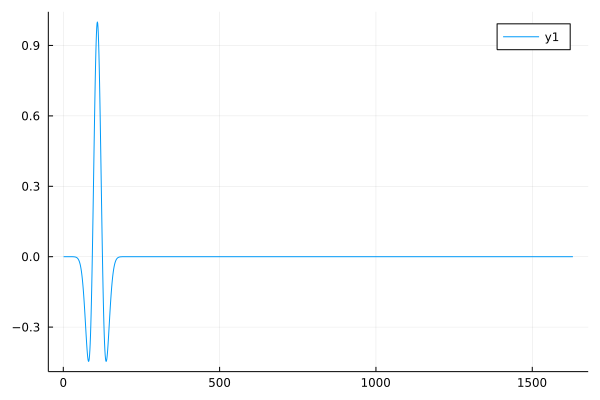

In [10]:
wav, tgrid=ricker(medium, 8, 1, 0.4)
dt=step(tgrid)

tmax=maximum(tgrid); nt=length(tgrid); 
print("nt:\t",length(tgrid))


freqmax=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:max)
freqpeak=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:peak)
freqmin=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:min)


srcwav = SrcWav(tgrid, ageom, [:tauyy])
GeoPhyInv.update!(srcwav, [:tauyy], wav)

plot(wav)

In [11]:
# CUDA.reclaim()
pa = SeisForwExpt(
    FdtdElastic(),
    npw = 1,
    medium = medium,
    ageom = [ageom],
    srcwav = [srcwav],
    sflags = [2],
    rflags = [1],
    tgrid = tgrid,
    verbose = true,
);


┌ Info: spatial sampling (9.35e+00) can be as high as 9.87e+00
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:36
┌ Info: time sampling (1.07e-03) can be as high as 1.16e-03
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:51
┌ Warning: Performing scalar indexing on task Task (runnable) @0x00001503c4abc400.
│ Invocation of setindex! resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/pawan/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


In [15]:

ENV["GKSwstype"] = "nul";
if (isdir("viz3D_out") == false)
    mkdir("viz3D_out")
else
    foreach(rm, filter(endswith(".png"), readdir("./viz3D_out", join = true)))
end;
loadpath = "./viz3D_out/";
anim1 = Animation(loadpath, String["slice y"])
nout=div(nt,100)
println("Animation directory: $(anim1.dir)")
GeoPhyInv.initialize!(localpart(pa.p))
@showprogress for it = 1:nt
    GeoPhyInv.advance!(pa.c, localpart(pa.p))
    # Visualisation

	GeoPhyInv.add_source!(it, 1, 1, pa.c, localpart(pa.p), GeoPhyInv.Source_B1())

    if mod(it, nout) == 0
        heatmap(
            Array(localpart(pa.p)[1].w1[:t][:vx])[1:end, div(ny,2), 1:end],
            aspect_ratio = 1,
            # xlims = (1, nx + 1),
            # ylims = (1, nz),
            c = :seismic,
            title = "vx",
            clims = (-0.01, 0.01),
        )
        frame(anim1)
    end

end


Animation directory: ./viz3D_out/


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


┌ Info: Saved animation to 
│   fn = /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif")
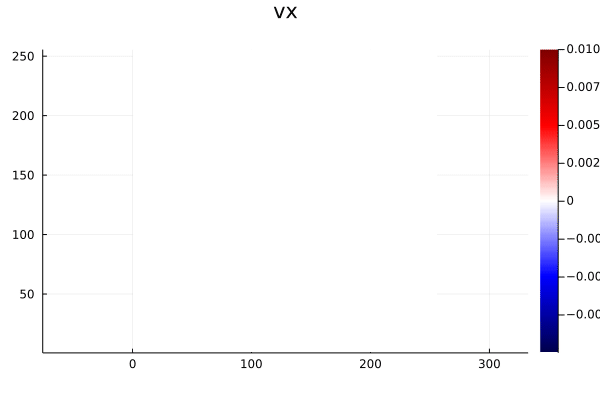

In [16]:
gif(anim1, "acoustic3D.gif", fps=30)


In [16]:
size(localpart(pa.p)[1].w1[:t][:dpdz])
# typeof(pa.c.mod[:M])

(1, 1, 1)

In [45]:
# gr()
pa.c.pml[:x][:a][end-16:end]


17-element CuArray{Float64, 1}:
 -0.0007667680832264844
 -0.0030674644961424698
 -0.006897311443491313
 -0.01224440127432702
 -0.01908977383385921
 -0.027407548624170122
 -0.03716511041654802
 -0.04832334637961726
 -0.06083693223526065
 -0.07465466443611499
 -0.08971983488126355
 -0.10597064425696497
 -0.12334064971238949
 -0.14175924226114445
 -0.16115214904147315
 -0.1814419553742531
 -0.20254864142993978

In [7]:

GeoPhyInv.check_fd_stability(medium.bounds, mgrid, tgrid, freqmin, freqmax, true, 10, 0.5)

┌ Info: spatial sampling (3.94e+00) can be as high as 5.01e+00
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:36
┌ Info: time sampling (4.50e-04) can be as high as 4.88e-04
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/stability.jl:51
